In [26]:
from __future__ import print_function
import time
import os
import torch
import numpy as np
import torch.nn.parallel
import torch.optim as optim
import torchvision.utils as vutils
from torch.autograd import Variable
from torch.nn.functional import dropout

import re
import sys
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Options

In [27]:
sys.argv = 'xz2yx_train.py --name xzyx_discrete_0 --checkpoints_dir ./checkpoints --output_nc 2 --dataset horse ' \
        + '--batchSize 4 --heightSize 32 --widthSize 32 --n_layers_D 3 --start_epoch 0 --niter 100 --niter_decay 50 ' \
        + '--resize_or_crop crop --ignore_index -100 --unsup_portion 9 --portion_total 10 --unsup_sampler sep ' \
        + '--port 1235 --gpu_ids 1 --stage X2Z:2,Z2Y:2,ZY2X:2,D:2 --lrs 1e-4,1e-4,1e-2,1e-2 --lambdas 1e-2,1e-0 ' \
        + '--z_nc 8 --x_drop 0.9 ' \
        + '--display_id 0'
sys.argv = sys.argv.split(' ')

from xz2yx_nets import *

In [28]:
opt = parser.parse_args()
opt.isTrain = True
opt.name += '_%s_b%d/stage%s/lr%s_lb%s' % (opt.dataset, opt.batchSize, opt.stage, opt.lrs, opt.lambdas)
opt.updates = {k_v.split(':')[0]:int(k_v.split(':')[1]) for k_v in opt.stage.split(',')}
opt.lrs = {k:(float(lr) if opt.updates[k] > 1 else 0.0)
            for k,lr in zip(opt.updates.keys(), opt.lrs.split(','))}
opt.lambdas = {k:float(lb) for k,lb in zip(['x','y'], opt.lambdas.split(','))}

assert(opt.unsup_sampler == 'sep')
#assert(opt.unsup_portion > 0)
print(opt)

# gpu id
#os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpu_ids # absolute ids
opt.gpu_ids = range(0,len(opt.gpu_ids)) # new range starting from 0

CLAMP_LOW = -0.01
CLAMP_UPP = 0.01
ANNEAL_RATE = 0.00003
MIN_TEMP = 0.5

lambda_x = opt.lambdas['x']
lambda_y = opt.lambdas['y']

Namespace(batchSize=4, beta1=0.5, checkpoints_dir='./checkpoints', dataset='horse', display_id=0, display_winsize=256, gpu_ids='1', heightSize=32, ignore_index=-100, input_nc=3, isTrain=True, lambdas={'x': 0.01, 'y': 1.0}, lr=0.0002, lr_decay_iters=50, lr_policy='lambda', lrs={'X2Z': 0.0001, 'Z2Y': 0.0001, 'ZY2X': 0.01, 'D': 0.01}, manual_seed=123, nThreads=4, n_layers_D=3, name='xzyx_discrete_0_horse_b4/stageX2Z:2,Z2Y:2,ZY2X:2,D:2/lr1e-4,1e-4,1e-2,1e-2_lb1e-2,1e-0', ndf=64, ngf=64, niter=100, niter_decay=50, no_flip=False, no_html=False, noise='sphere', output_nc=2, port=1235, portion_total=10, resize_or_crop='crop', save_every=2, stage='X2Z:2,Z2Y:2,ZY2X:2,D:2', start_epoch=0, unsup_portion=9, unsup_sampler='sep', updates={'X2Z': 2, 'Z2Y': 2, 'ZY2X': 2, 'D': 2}, use_dropout=False, which_direction='AtoB', widthSize=32, x_drop=0.9, z_nc=8)


# data_loaders

In [29]:
from data.data_loader import CreateDataLoader,InfiniteDataLoader,XYDataLoader
from util.visualizer import Visualizer

opt.phase = 'val'
opt.isTrain = False
val_loader = CreateDataLoader(opt)
opt = val_loader.update_opt(opt)

opt.phase = 'train'
opt.isTrain = True
paired_loader = XYDataLoader(opt, is_paired=True)
x_loader = XYDataLoader(opt, is_paired=False) # will use x only
y_loader = XYDataLoader(opt, is_paired=False) # will use y only

# wrap with infinite loader
paired_loader = InfiniteDataLoader(paired_loader)
x_loader = InfiniteDataLoader(x_loader)
y_loader = InfiniteDataLoader(y_loader)

# Visualizer
visualizer = Visualizer(opt)

===> dataset [HorseDataset] was created
==> unsupervised portion = 0.900
===> dataset [HorseDataset] was created
==> unsupervised portion = 0.900
===> dataset [HorseDataset] was created
==> unsupervised portion = 0.900
===> dataset [HorseDataset] was created
===> Create results directory: ./checkpoints/xzyx_discrete_0_horse_b4/stageX2Z:2,Z2Y:2,ZY2X:2,D:2/lr1e-4,1e-4,1e-2,1e-2_lb1e-2,1e-0/results
==> OPTIONS:
xz2yx_train.py --name xzyx_discrete_0 --checkpoints_dir ./checkpoints --output_nc 2 --dataset horse --batchSize 4 --heightSize 32 --widthSize 32 --n_layers_D 3 --start_epoch 0 --niter 100 --niter_decay 50 --resize_or_crop crop --ignore_index -100 --unsup_portion 9 --portion_total 10 --unsup_sampler sep --port 1235 --gpu_ids 1 --stage X2Z:2,Z2Y:2,ZY2X:2,D:2 --lrs 1e-4,1e-4,1e-2,1e-2 --lambdas 1e-2,1e-0 --z_nc 8 --x_drop 0.9 --display_id 0



# networks

In [30]:
net =dict()
net['X2Z'] = FX2Z(opt)
net['Z2Y'] = FZ2Y(opt)
net['ZY2X'] = GZ2X(opt) # TODO: ZY2X to Z2X
net['D'] = NLayerDiscriminator(opt)

for k in net.keys():
    if len(opt.gpu_ids) > 0:
        net[k].cuda(opt.gpu_ids[0])

    # init
    net[k].apply(weights_init)

    # load if found saved weights
    weights_fpath = os.path.join(opt.checkpoints_dir, opt.name, 'net%s.pth' % (k))
    if os.path.exists(weights_fpath):
        print('Load net[%s] from %s' % (k, weights_fpath))
        net[k].load_state_dict(torch.load(weights_fpath, map_location=lambda storage, loc: storage))

    # train or freeze
    if opt.updates[k] == 2:
        print('Training net[%s]' % k)
        net[k].train()
        for param in net[k].parameters():
            param.requires_grad = True
    else:
        print('Freezing or disabling net[%s]' % k)
        net[k].eval() # NOTE: to disable batchnorm updates
        for param in net[k].parameters():
            param.requires_grad = False

Training net[X2Z]
Training net[Z2Y]
Training net[ZY2X]
Training net[D]


# optimizers

In [31]:
from torch.optim import lr_scheduler

def get_scheduler(optimizer):
    if opt.lr_policy == 'lambda':
        def lambda_rule(epoch): # decay to 0 starting from epoch=niter_decay
            lr_l = 1.0 - max(0, epoch + 1 + opt.start_epoch - opt.niter + opt.niter_decay) / float(opt.niter_decay + 1)
            return lr_l
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif opt.lr_policy == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=opt.lr_decay_iters, gamma=0.1)
    elif opt.lr_policy == 'plateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', opt.lr_policy)
    return scheduler

optimizers = dict()
schedulers = dict()
for k in net.keys():
    if opt.updates[k] == 2:
        print('Creating optimizer for net[%s]' % k)
        optimizers[k] = optim.Adam(net[k].parameters(), lr=opt.lrs[k], betas=(opt.beta1, 0.999))
        schedulers[k] = get_scheduler(optimizers[k])

def adjust_lr(epoch):
    print('===> Start of epoch %d / %d' % (epoch, opt.niter))
    for k,sch in schedulers.items():
        sch.step()
        lr = optimizers[k].param_groups[0]['lr']
        print('%s: learning rate = %.7f' % (k,lr))

Creating optimizer for net[X2Z]
Creating optimizer for net[Z2Y]
Creating optimizer for net[ZY2X]
Creating optimizer for net[D]


# losses, variables

In [32]:
CE, L1 = create_losses(opt)

t_x = torch.FloatTensor(opt.batchSize, opt.input_nc, opt.heightSize, opt.widthSize)
t_y_int = torch.LongTensor(opt.batchSize, opt.heightSize, opt.widthSize)

heightSize = val_loader.dataset.heightSize
widthSize = val_loader.dataset.widthSize
xx = torch.FloatTensor(1, opt.input_nc, heightSize, widthSize)
yy_int = torch.LongTensor(1, heightSize, widthSize)

if len(opt.gpu_ids) > 0:
    t_x = t_x.cuda(opt.gpu_ids[0])
    t_y_int = t_y_int.cuda(opt.gpu_ids[0])
    xx = xx.cuda(opt.gpu_ids[0])
    yy_int = yy_int.cuda(opt.gpu_ids[0])

# Train functions

In [ ]:
def generate_var_x(tensor=t_x, loader=x_loader):
    populate_xy(tensor, None, loader, opt)
    v_x = Variable(tensor)
    return v_x

def generate_var_y(tensor=t_y_int, loader=y_loader, temperature=0.0):
    populate_xy(None, tensor, loader, opt)
    v_y_int = Variable(tensor, requires_grad=False)
    v_y = Variable(one_hot(tensor, opt))
    log_y = noise_log_y(v_y, temperature, opt.gpu_ids)
    return (v_y_int, log_y)

def generate_var_xy(tensors=[t_x,t_y_int], loader=paired_loader, volatile=False, temperature=0.0):
    populate_xy(tensors[0], tensors[1], loader, opt)
    v_x = Variable(tensors[0], volatile=volatile)
    v_y_int = Variable(tensors[1], requires_grad=False, volatile=volatile)
    v_y = Variable(one_hot(tensors[1], opt), volatile=volatile)
    log_y = noise_log_y(v_y, temperature, opt.gpu_ids)
    return (v_x, v_y_int, log_y)

def Y_step(v_x, v_y_int):
    z_hat = net['X2Z'](v_x)
    y_hat = net['Z2Y'](z_hat)
    loss = None if v_y_int is None else CE(y_hat, v_y_int)
    return (z_hat, y_hat, loss)

def X_step(z_hat, v_x_drop, v_x):
    x_inf = net['ZY2X'](z_hat, v_x_drop)
    return (x_inf, L1(x_inf, v_x))

def update_FHG(g_losses):
    global g_it
    net['X2Z'].zero_grad()
    net['Z2Y'].zero_grad()
    net['ZY2X'].zero_grad()
    sum(g_losses).backward()
    if opt.updates['X2Z'] == 2: optimizers['X2Z'].step()
    if opt.updates['Z2Y'] == 2: optimizers['Z2Y'].step()
    if opt.updates['ZY2X'] == 2: optimizers['ZY2X'].step()
    del g_losses[:] # empty affects outside
    g_it += 1

def D_step(v_x):
    z_hat = net['X2Z'](v_x)
    #y_hat = net['Z2Y'](z_hat)
    x_hat = net['ZY2X'](z_hat, v_x)

    E_q_D = net['D']( x_hat.detach() ).mean()
    E_p_D = net['D']( v_x ).mean()
    d_loss = -lambda_x * (E_q_D - E_p_D).pow(2)

    optimizers['D'].zero_grad()
    d_loss.backward()
    optimizers['D'].step()
    # clamp parameters to a cube
    for p in net['D'].parameters():
        p.data.clamp_(CLAMP_LOW, CLAMP_UPP)

    return d_loss

def mask_drop(v_x):
    v_x0 = dropout(v_x[:,0,:,:], p=opt.x_drop, training=True)
    mask = v_x0.le(0).unsqueeze_(1).detach()
    v_x_drop = v_x.masked_fill(mask, 0)
    return v_x_drop

# Evaluation

In [34]:
from util.meter import SegmentationMeter

def evaluation(epoch, do_G=False, subset='train'):
    net['X2Z'].eval()
    net['Z2Y'].eval()
    if do_G: net['ZY2X'].eval()

    eval_stats = SegmentationMeter(n_class=opt.output_nc, ignore_index=opt.ignore_index)
    E_loss = [[0], [0], [0]] # CE, A_L1, P_L1

    lval = len(val_loader)
    start_time = time.time()
    val_loader_iter = iter(val_loader)
    for i in range(lval):
        v_x, v_y_int, log_y = generate_var_xy([xx, yy_int], val_loader_iter, True)

        z_hat, y_hat, P_CE = Y_step(v_x, v_y_int)
        E_loss[0].append( P_CE.data[0] )

        logits = y_hat.data.cpu().numpy()
        pred = logits.argmax(1) # NCHW -> NHW
        gt = yy_int.cpu().numpy()
        eval_stats.update_confmat(gt, pred)

        if do_G:
            v_x_drop = mask_drop(v_x)
            x_hat, A_L1 = X_step(z_hat, v_x_drop, v_x)
            #x_tilde, P_L1 = X_step(z_hat, log_y, v_x)
            E_loss[1].append( A_L1.data[0] )
            #E_loss[2].append( P_L1.data[0] )
            E_loss[2].append( A_L1.data[0] )

        # visualization
        if i % 50 == 0:
            images = {'T_x':v_x.data.cpu(),
                      'T_y':v_y_int.data.cpu().numpy(), 'T_y_hat':y_hat.data.cpu().numpy().argmax(1),
                      'T_z_hat':z_hat.data.cpu().numpy().argmax(1)}
            if do_G:
                images['T_x_drop']   = v_x_drop.data.cpu()
                images['T_x_hat']   = x_hat.data.cpu()
                #images['T_x_tilde'] = x_tilde.data.cpu()
            display_imgs(images, epoch, i, subset=subset, do_save=2)

    print('EVAL at epoch %d ==> CE = %.3f, A_L1 = %.3f, P_L1 = %.3f' % \
            (epoch, sum(E_loss[0])/lval, sum(E_loss[1])/lval, sum(E_loss[2])/lval))
    eval_results = eval_stats.get_eval_results()
    msg = 'EVAL at epoch %d [%d images in %.2f sec] ==> %s\n' % \
            (epoch, lval, time.time()-start_time, eval_results[0])
    msg += 'Per-class IoU:\n'
    msg += ''.join(['%s: %.2f\n' % (cname,ciu)
                    for cname,ciu in zip(val_loader.dataset.label2name, eval_results[1])])
    print(msg)
    with open(visualizer.log_name, "a") as log_file:
        log_file.write('%s' % msg)

    if opt.updates['X2Z'] == 2:
        net['X2Z'].train()
    if opt.updates['Z2Y'] == 2:
        net['Z2Y'].train()
    if opt.updates['ZY2X'] == 2:
        net['ZY2X'].train()

    return eval_results[0]['Mean IoU']

In [35]:
def plot_dict_figures(figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.
    figures : <title, figure> dictionary
    """
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in zip(range(len(figures)), figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.jet())
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

#from util.util import tensor2lab
def tensor2lab(lab_tensor, n_labs):
    label2color = plt.cm.jet(np.linspace(0,1,n_labs), bytes=True)[:,0:3]
    seg_map = lab_tensor[0] # HW
    seg_map = seg_map.astype(np.int32)
    assert(len(seg_map.shape) == 2)
    seg_image = label2color[seg_map].astype(np.uint8) # HW3
    return seg_image.transpose((2,0,1)) # 3HW

def display_imgs(images, epoch, i, subset='train', do_save=0):
    for k, im in images.items():
        if 'y' in k:
            images[k] = tensor2lab(im, opt.output_nc) # 3HW
        elif 'z' in k:
            images[k] = tensor2lab(im, opt.z_nc) # 3HW
        elif 'x' in k:
            images[k] = im[0] # 3HW
            d_mean = torch.FloatTensor(val_loader.dataset.mean).view(-1,1,1) # (3) -> (3,1,1)
            d_std = torch.FloatTensor(val_loader.dataset.std).view(-1,1,1)
            images[k] *= d_std
            images[k] += d_mean
            images[k] = images[k].mul(255).clamp(0,255).byte().numpy() # 3HW
            
    #visualizer.display_current_results(images, epoch, i, subset=subset, do_save=do_save)
    images = {k:v.transpose(1, 2, 0) for k,v in images.items()}
    plot_dict_figures(images, 1, len(images))
    

# Main loop

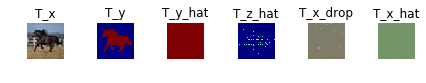

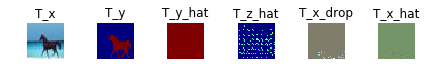

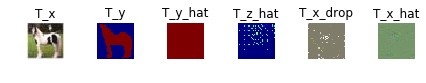

EVAL at epoch 0 ==> CE = 0.717, A_L1 = 0.221, P_L1 = 0.221
EVAL at epoch 0 [127 images in 1.74 sec] ==> {'Overall Acc': 0.29313791830708663, 'Mean Acc': 0.5, 'FreqW Acc': 0.0859298391494122, 'Mean IoU': 0.14656895915354332}
Per-class IoU:
Background: 0.00
Horse: 0.29



In [ ]:
mIoU = evaluation(0, do_G=True)
stats = {'D':0, 'G':0, 'P_CE':0, 'A_CE':0, 'P_L1':0, 'A_L1':0}
g_it = 0

===> Start of epoch 0 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[0/100][0/50] in 0.689s (0.480,0.175,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.706/0.000 P_L1/A_L1: 0.587/0.430 


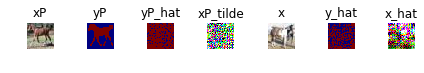

===> End of epoch 0 / 100 	 Time Taken: 10.37 sec



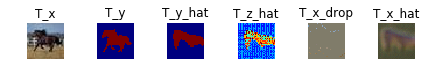

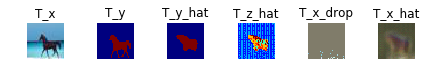

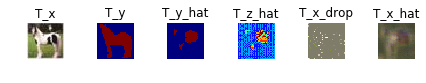

EVAL at epoch 0 ==> CE = 0.435, A_L1 = 0.225, P_L1 = 0.225
EVAL at epoch 0 [127 images in 1.73 sec] ==> {'Overall Acc': 0.7978592519685039, 'Mean Acc': 0.6806448838955043, 'FreqW Acc': 0.652299983928791, 'Mean IoU': 0.5683861276364054}
Per-class IoU:
Background: 0.77
Horse: 0.37

===> Start of epoch 1 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[1/100][0/50] in 0.290s (0.036,0.224,0.030) D/G: 0.000/0.000 P_CE/A_CE: 0.304/0.000 P_L1/A_L1: 0.151/0.183 


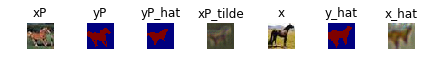

===> End of epoch 1 / 100 	 Time Taken: 5.53 sec

===> Start of epoch 2 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[2/100][0/50] in 0.392s (0.035,0.317,0.041) D/G: 0.000/0.000 P_CE/A_CE: 0.179/0.000 P_L1/A_L1: 0.121/0.131 


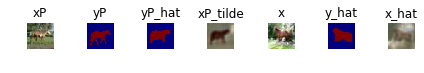

===> End of epoch 2 / 100 	 Time Taken: 6.13 sec



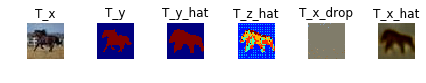

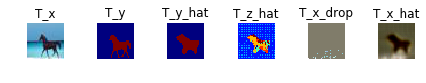

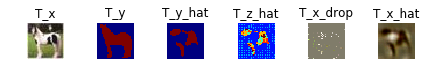

EVAL at epoch 2 ==> CE = 0.403, A_L1 = 0.227, P_L1 = 0.227
EVAL at epoch 2 [127 images in 1.97 sec] ==> {'Overall Acc': 0.8354838213582677, 'Mean Acc': 0.7797644388597442, 'FreqW Acc': 0.7202117027167508, 'Mean IoU': 0.6659395005474376}
Per-class IoU:
Background: 0.80
Horse: 0.53

===> Start of epoch 3 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[3/100][0/50] in 0.311s (0.034,0.242,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.135/0.000 P_L1/A_L1: 0.188/0.195 


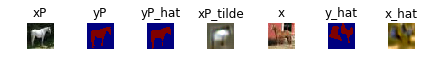

===> End of epoch 3 / 100 	 Time Taken: 5.40 sec

===> Start of epoch 4 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[4/100][0/50] in 0.284s (0.034,0.219,0.031) D/G: 0.000/0.001 P_CE/A_CE: 0.104/0.000 P_L1/A_L1: 0.129/0.117 


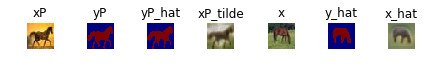

===> End of epoch 4 / 100 	 Time Taken: 5.35 sec



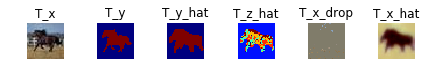

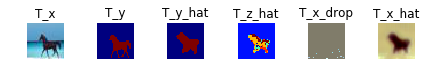

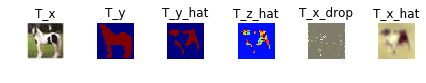

EVAL at epoch 4 ==> CE = 0.419, A_L1 = 0.233, P_L1 = 0.233
EVAL at epoch 4 [127 images in 1.58 sec] ==> {'Overall Acc': 0.8474947711614174, 'Mean Acc': 0.7937415158087591, 'FreqW Acc': 0.7373571647109893, 'Mean IoU': 0.6856364370432447}
Per-class IoU:
Background: 0.81
Horse: 0.56

===> Start of epoch 5 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[5/100][0/50] in 0.863s (0.579,0.252,0.031) D/G: 0.000/0.000 P_CE/A_CE: 0.064/0.000 P_L1/A_L1: 0.181/0.180 


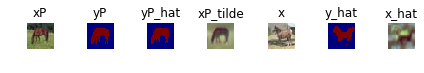

===> End of epoch 5 / 100 	 Time Taken: 5.92 sec

===> Start of epoch 6 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[6/100][0/50] in 0.316s (0.036,0.247,0.033) D/G: 0.000/0.000 P_CE/A_CE: 0.055/0.000 P_L1/A_L1: 0.143/0.127 


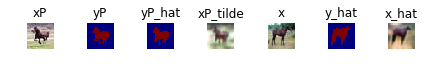

===> End of epoch 6 / 100 	 Time Taken: 5.54 sec



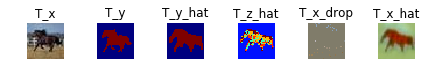

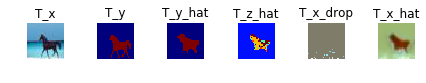

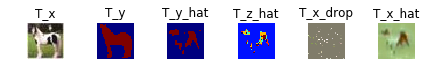

EVAL at epoch 6 ==> CE = 0.506, A_L1 = 0.197, P_L1 = 0.197
EVAL at epoch 6 [127 images in 1.71 sec] ==> {'Overall Acc': 0.8457415723425197, 'Mean Acc': 0.7778774104406849, 'FreqW Acc': 0.7317292883253648, 'Mean IoU': 0.6751589067840867}
Per-class IoU:
Background: 0.81
Horse: 0.54

===> Start of epoch 7 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[7/100][0/50] in 0.332s (0.046,0.254,0.032) D/G: 0.000/0.001 P_CE/A_CE: 0.033/0.000 P_L1/A_L1: 0.122/0.199 


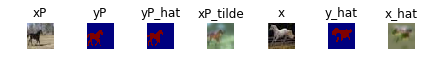

===> End of epoch 7 / 100 	 Time Taken: 5.83 sec

===> Start of epoch 8 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[8/100][0/50] in 0.393s (0.043,0.308,0.043) D/G: 0.000/0.000 P_CE/A_CE: 0.034/0.000 P_L1/A_L1: 0.146/0.182 


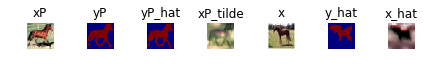

===> End of epoch 8 / 100 	 Time Taken: 5.99 sec



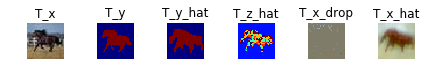

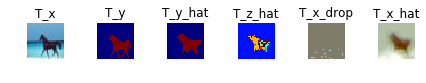

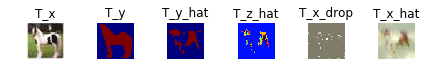

EVAL at epoch 8 ==> CE = 0.499, A_L1 = 0.242, P_L1 = 0.242
EVAL at epoch 8 [127 images in 1.87 sec] ==> {'Overall Acc': 0.849494032972441, 'Mean Acc': 0.7903270974055092, 'FreqW Acc': 0.7390350929150193, 'Mean IoU': 0.685959560266665}
Per-class IoU:
Background: 0.81
Horse: 0.56

===> Start of epoch 9 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[9/100][0/50] in 0.307s (0.037,0.236,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.013/0.000 P_L1/A_L1: 0.203/0.140 


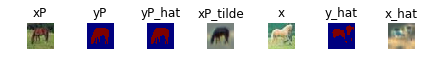

===> End of epoch 9 / 100 	 Time Taken: 5.35 sec

===> Start of epoch 10 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[10/100][0/50] in 0.580s (0.333,0.203,0.044) D/G: 0.000/0.000 P_CE/A_CE: 0.013/0.000 P_L1/A_L1: 0.139/0.142 


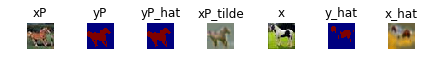

===> End of epoch 10 / 100 	 Time Taken: 5.96 sec



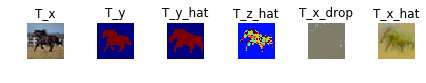

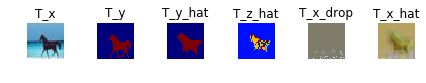

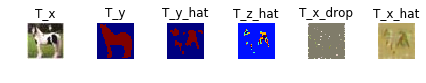

EVAL at epoch 10 ==> CE = 0.561, A_L1 = 0.212, P_L1 = 0.212
EVAL at epoch 10 [127 images in 1.66 sec] ==> {'Overall Acc': 0.8490634227362205, 'Mean Acc': 0.7866601412641423, 'FreqW Acc': 0.7377012056653312, 'Mean IoU': 0.6835152379896734}
Per-class IoU:
Background: 0.81
Horse: 0.55

===> Start of epoch 11 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[11/100][0/50] in 0.344s (0.057,0.249,0.039) D/G: 0.000/0.000 P_CE/A_CE: 0.007/0.000 P_L1/A_L1: 0.157/0.122 


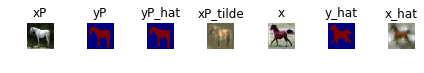

===> End of epoch 11 / 100 	 Time Taken: 5.46 sec

===> Start of epoch 12 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[12/100][0/50] in 0.371s (0.035,0.294,0.042) D/G: 0.000/0.000 P_CE/A_CE: 0.005/0.000 P_L1/A_L1: 0.129/0.152 


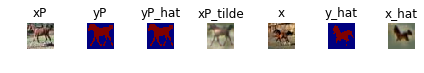

===> End of epoch 12 / 100 	 Time Taken: 6.00 sec



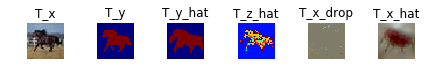

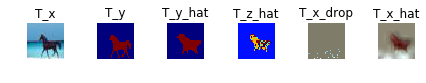

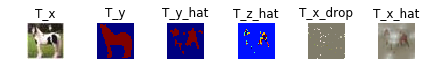

EVAL at epoch 12 ==> CE = 0.610, A_L1 = 0.173, P_L1 = 0.173
EVAL at epoch 12 [127 images in 1.80 sec] ==> {'Overall Acc': 0.8487097071850394, 'Mean Acc': 0.7857036901862324, 'FreqW Acc': 0.7370626943078978, 'Mean IoU': 0.6826189370892046}
Per-class IoU:
Background: 0.81
Horse: 0.55

===> Start of epoch 13 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[13/100][0/50] in 0.302s (0.037,0.231,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.003/0.000 P_L1/A_L1: 0.127/0.122 


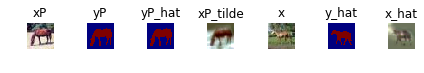

===> End of epoch 13 / 100 	 Time Taken: 5.36 sec

===> Start of epoch 14 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[14/100][0/50] in 0.282s (0.034,0.214,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.004/0.000 P_L1/A_L1: 0.161/0.119 


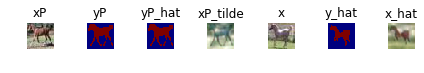

===> End of epoch 14 / 100 	 Time Taken: 5.37 sec



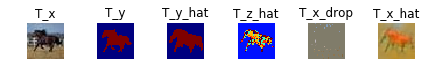

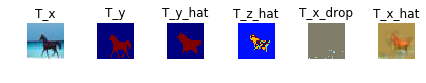

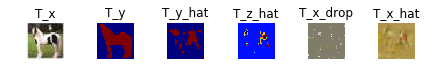

EVAL at epoch 14 ==> CE = 0.658, A_L1 = 0.219, P_L1 = 0.219
EVAL at epoch 14 [127 images in 1.54 sec] ==> {'Overall Acc': 0.8485251599409449, 'Mean Acc': 0.7844216561176915, 'FreqW Acc': 0.7365479597849186, 'Mean IoU': 0.6817152254010244}
Per-class IoU:
Background: 0.81
Horse: 0.55

===> Start of epoch 15 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[15/100][0/50] in 0.592s (0.343,0.218,0.031) D/G: 0.000/0.000 P_CE/A_CE: 0.001/0.000 P_L1/A_L1: 0.227/0.161 


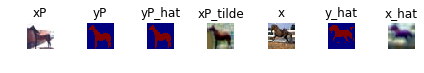

===> End of epoch 15 / 100 	 Time Taken: 5.55 sec

===> Start of epoch 16 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[16/100][0/50] in 0.283s (0.033,0.218,0.033) D/G: 0.000/0.000 P_CE/A_CE: 0.001/0.000 P_L1/A_L1: 0.144/0.157 


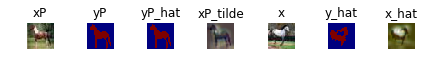

===> End of epoch 16 / 100 	 Time Taken: 5.79 sec



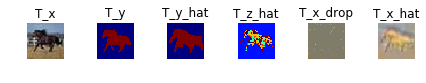

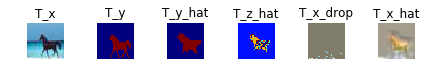

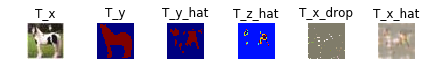

EVAL at epoch 16 ==> CE = 0.699, A_L1 = 0.230, P_L1 = 0.230
EVAL at epoch 16 [127 images in 1.94 sec] ==> {'Overall Acc': 0.8475485974409449, 'Mean Acc': 0.7818577857318402, 'FreqW Acc': 0.7347957318076466, 'Mean IoU': 0.6792687270401949}
Per-class IoU:
Background: 0.81
Horse: 0.55

===> Start of epoch 17 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[17/100][0/50] in 0.293s (0.041,0.221,0.031) D/G: 0.000/0.000 P_CE/A_CE: 0.002/0.000 P_L1/A_L1: 0.147/0.149 


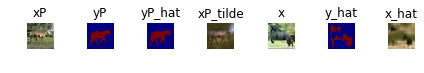

===> End of epoch 17 / 100 	 Time Taken: 5.31 sec

===> Start of epoch 18 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[18/100][0/50] in 0.348s (0.034,0.272,0.042) D/G: 0.000/0.000 P_CE/A_CE: 0.001/0.000 P_L1/A_L1: 0.128/0.131 


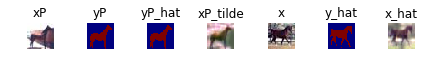

===> End of epoch 18 / 100 	 Time Taken: 6.15 sec



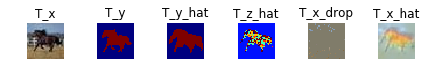

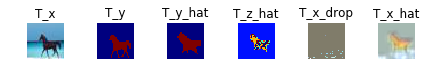

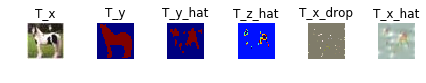

EVAL at epoch 18 ==> CE = 0.703, A_L1 = 0.276, P_L1 = 0.276
EVAL at epoch 18 [127 images in 1.89 sec] ==> {'Overall Acc': 0.8490172859251969, 'Mean Acc': 0.7883547477484562, 'FreqW Acc': 0.7380287866960804, 'Mean IoU': 0.6843930659066804}
Per-class IoU:
Background: 0.81
Horse: 0.55

===> Start of epoch 19 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[19/100][0/50] in 0.302s (0.052,0.217,0.033) D/G: 0.000/0.000 P_CE/A_CE: 0.001/0.000 P_L1/A_L1: 0.122/0.112 


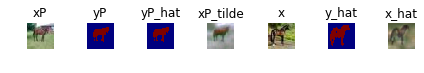

===> End of epoch 19 / 100 	 Time Taken: 5.31 sec

===> Start of epoch 20 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[20/100][0/50] in 0.737s (0.526,0.178,0.032) D/G: 0.000/0.000 P_CE/A_CE: 0.001/0.000 P_L1/A_L1: 0.132/0.146 


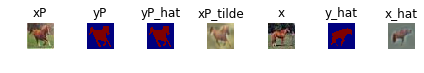

===> End of epoch 20 / 100 	 Time Taken: 6.21 sec



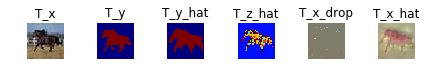

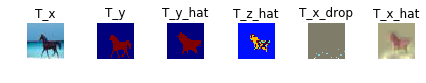

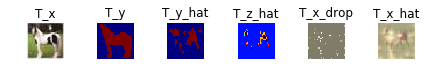

EVAL at epoch 20 ==> CE = 0.731, A_L1 = 0.220, P_L1 = 0.220
EVAL at epoch 20 [127 images in 1.99 sec] ==> {'Overall Acc': 0.8486405019685039, 'Mean Acc': 0.7877811638837978, 'FreqW Acc': 0.7374516296523597, 'Mean IoU': 0.6836862942728672}
Per-class IoU:
Background: 0.81
Horse: 0.55

===> Start of epoch 21 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[21/100][0/50] in 0.284s (0.033,0.217,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.093/0.188 


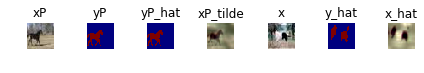

===> End of epoch 21 / 100 	 Time Taken: 5.13 sec

===> Start of epoch 22 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[22/100][0/50] in 0.275s (0.031,0.210,0.033) D/G: 0.000/0.000 P_CE/A_CE: 0.001/0.000 P_L1/A_L1: 0.156/0.126 


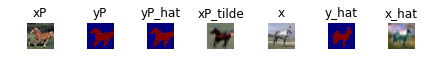

===> End of epoch 22 / 100 	 Time Taken: 5.59 sec



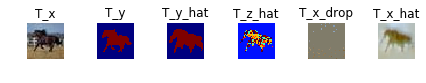

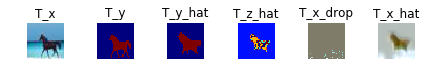

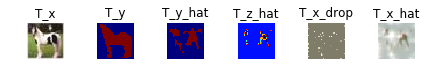

EVAL at epoch 22 ==> CE = 0.780, A_L1 = 0.278, P_L1 = 0.278
EVAL at epoch 22 [127 images in 1.74 sec] ==> {'Overall Acc': 0.8478023499015748, 'Mean Acc': 0.7882783769651478, 'FreqW Acc': 0.736563770170841, 'Mean IoU': 0.6830781452455635}
Per-class IoU:
Background: 0.81
Horse: 0.55

===> Start of epoch 23 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[23/100][0/50] in 0.319s (0.033,0.253,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.152/0.134 


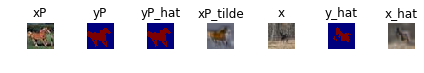

===> End of epoch 23 / 100 	 Time Taken: 5.17 sec

===> Start of epoch 24 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[24/100][0/50] in 0.274s (0.031,0.208,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.161/0.120 


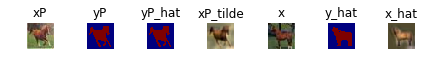

===> End of epoch 24 / 100 	 Time Taken: 5.56 sec



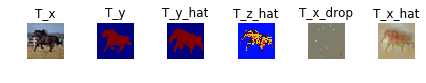

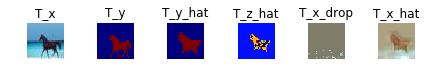

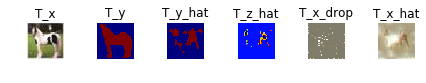

EVAL at epoch 24 ==> CE = 0.771, A_L1 = 0.209, P_L1 = 0.209
EVAL at epoch 24 [127 images in 1.81 sec] ==> {'Overall Acc': 0.8484790231299213, 'Mean Acc': 0.7915206091201774, 'FreqW Acc': 0.7380763954802968, 'Mean IoU': 0.6855209331030068}
Per-class IoU:
Background: 0.81
Horse: 0.56

===> Start of epoch 25 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[25/100][0/50] in 0.558s (0.329,0.195,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.140/0.156 


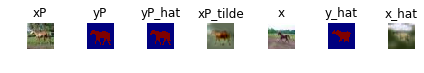

===> End of epoch 25 / 100 	 Time Taken: 5.42 sec

===> Start of epoch 26 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[26/100][0/50] in 0.263s (0.033,0.196,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.116/0.146 


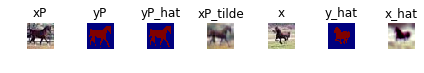

===> End of epoch 26 / 100 	 Time Taken: 5.19 sec



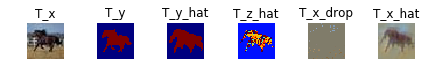

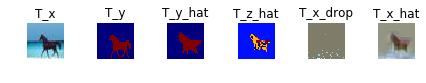

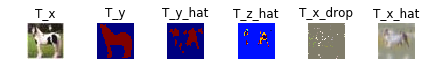

EVAL at epoch 26 ==> CE = 0.789, A_L1 = 0.183, P_L1 = 0.183
EVAL at epoch 26 [127 images in 1.58 sec] ==> {'Overall Acc': 0.847902312992126, 'Mean Acc': 0.7904601588723912, 'FreqW Acc': 0.7371578207641103, 'Mean IoU': 0.6843503310959428}
Per-class IoU:
Background: 0.81
Horse: 0.56

===> Start of epoch 27 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[27/100][0/50] in 0.282s (0.035,0.213,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.139/0.122 


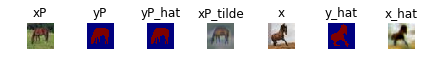

===> End of epoch 27 / 100 	 Time Taken: 5.19 sec

===> Start of epoch 28 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[28/100][0/50] in 0.373s (0.034,0.303,0.036) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.210/0.142 


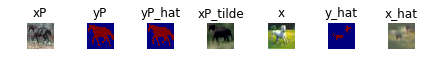

===> End of epoch 28 / 100 	 Time Taken: 6.21 sec



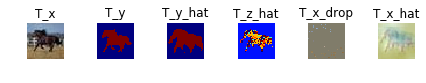

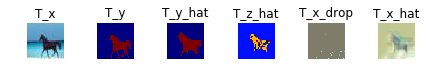

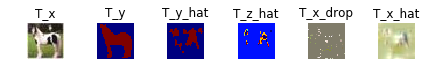

EVAL at epoch 28 ==> CE = 0.790, A_L1 = 0.283, P_L1 = 0.283
EVAL at epoch 28 [127 images in 2.09 sec] ==> {'Overall Acc': 0.8471179872047244, 'Mean Acc': 0.7944345756592972, 'FreqW Acc': 0.7370437537949918, 'Mean IoU': 0.6855920371528303}
Per-class IoU:
Background: 0.81
Horse: 0.56

===> Start of epoch 29 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[29/100][0/50] in 0.295s (0.037,0.226,0.032) D/G: 0.000/0.000 P_CE/A_CE: 0.001/0.000 P_L1/A_L1: 0.242/0.144 


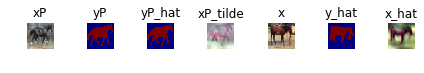

===> End of epoch 29 / 100 	 Time Taken: 5.56 sec

===> Start of epoch 30 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[30/100][0/50] in 0.599s (0.369,0.195,0.035) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.140/0.125 


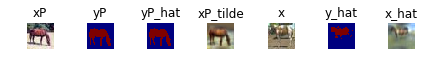

===> End of epoch 30 / 100 	 Time Taken: 5.64 sec



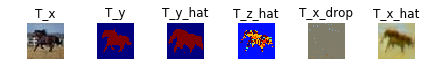

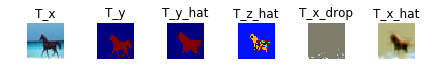

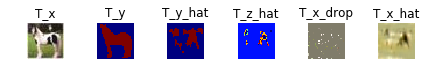

EVAL at epoch 30 ==> CE = 0.807, A_L1 = 0.203, P_L1 = 0.203
EVAL at epoch 30 [127 images in 1.60 sec] ==> {'Overall Acc': 0.8473563607283464, 'Mean Acc': 0.79454945314434, 'FreqW Acc': 0.7373549442909678, 'Mean IoU': 0.6859047633031189}
Per-class IoU:
Background: 0.81
Horse: 0.56

===> Start of epoch 31 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[31/100][0/50] in 0.344s (0.051,0.249,0.044) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.209/0.124 


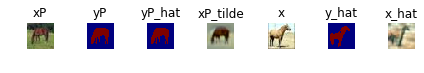

===> End of epoch 31 / 100 	 Time Taken: 5.49 sec

===> Start of epoch 32 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[32/100][0/50] in 0.276s (0.033,0.211,0.033) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.145/0.208 


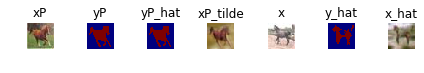

===> End of epoch 32 / 100 	 Time Taken: 5.83 sec



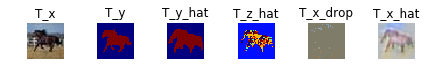

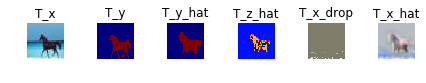

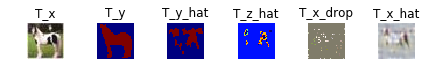

EVAL at epoch 32 ==> CE = 0.814, A_L1 = 0.272, P_L1 = 0.272
EVAL at epoch 32 [127 images in 1.89 sec] ==> {'Overall Acc': 0.844841904527559, 'Mean Acc': 0.7963404809028909, 'FreqW Acc': 0.7346659461245959, 'Mean IoU': 0.6841313726347238}
Per-class IoU:
Background: 0.81
Horse: 0.56

===> Start of epoch 33 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[33/100][0/50] in 0.307s (0.042,0.230,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.235/0.147 


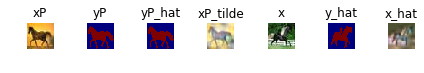

===> End of epoch 33 / 100 	 Time Taken: 5.38 sec

===> Start of epoch 34 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[34/100][0/50] in 0.350s (0.034,0.273,0.043) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.103/0.128 


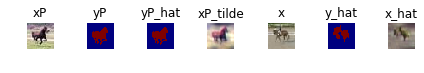

===> End of epoch 34 / 100 	 Time Taken: 5.98 sec



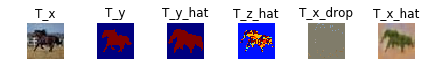

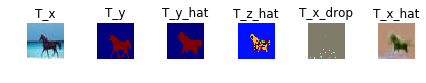

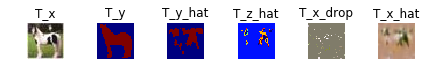

EVAL at epoch 34 ==> CE = 0.852, A_L1 = 0.188, P_L1 = 0.188
EVAL at epoch 34 [127 images in 1.97 sec] ==> {'Overall Acc': 0.844603531003937, 'Mean Acc': 0.7988203038768568, 'FreqW Acc': 0.7348436410416511, 'Mean IoU': 0.6850994990638886}
Per-class IoU:
Background: 0.81
Horse: 0.56

===> Start of epoch 35 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[35/100][0/50] in 0.765s (0.521,0.210,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.086/0.109 


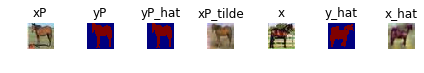

===> End of epoch 35 / 100 	 Time Taken: 5.70 sec

===> Start of epoch 36 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[36/100][0/50] in 0.269s (0.033,0.203,0.033) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.152/0.162 


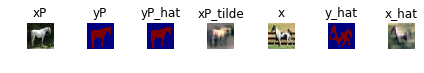

===> End of epoch 36 / 100 	 Time Taken: 5.36 sec



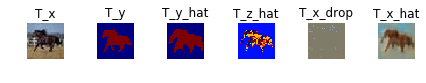

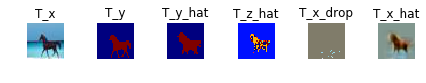

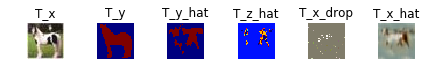

EVAL at epoch 36 ==> CE = 0.822, A_L1 = 0.171, P_L1 = 0.171
EVAL at epoch 36 [127 images in 1.64 sec] ==> {'Overall Acc': 0.843988373523622, 'Mean Acc': 0.8016323851582443, 'FreqW Acc': 0.7346008785489793, 'Mean IoU': 0.6857934777785082}
Per-class IoU:
Background: 0.80
Horse: 0.57

===> Start of epoch 37 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[37/100][0/50] in 0.289s (0.041,0.215,0.032) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.108/0.174 


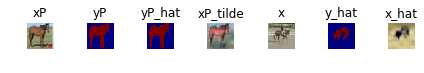

===> End of epoch 37 / 100 	 Time Taken: 5.18 sec

===> Start of epoch 38 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[38/100][0/50] in 0.262s (0.034,0.194,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.185/0.414 


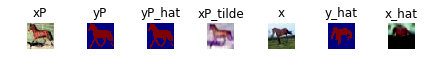

===> End of epoch 38 / 100 	 Time Taken: 5.76 sec



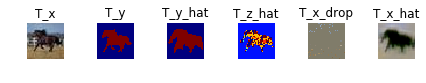

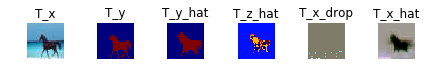

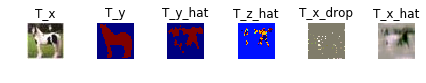

EVAL at epoch 38 ==> CE = 0.857, A_L1 = 0.184, P_L1 = 0.184
EVAL at epoch 38 [127 images in 1.92 sec] ==> {'Overall Acc': 0.8421967273622047, 'Mean Acc': 0.8024914875571565, 'FreqW Acc': 0.7325532348214078, 'Mean IoU': 0.684267437534619}
Per-class IoU:
Background: 0.80
Horse: 0.57

===> Start of epoch 39 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[39/100][0/50] in 0.286s (0.041,0.213,0.032) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.220/0.129 


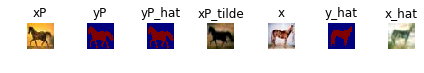

===> End of epoch 39 / 100 	 Time Taken: 5.31 sec

===> Start of epoch 40 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[40/100][0/50] in 0.576s (0.338,0.207,0.031) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.086/0.107 


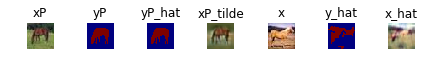

===> End of epoch 40 / 100 	 Time Taken: 6.22 sec



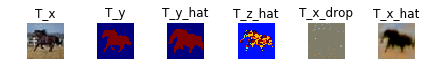

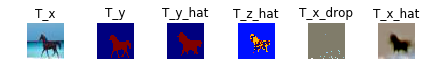

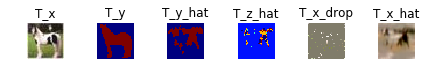

EVAL at epoch 40 ==> CE = 0.867, A_L1 = 0.178, P_L1 = 0.178
EVAL at epoch 40 [127 images in 1.98 sec] ==> {'Overall Acc': 0.8408587598425197, 'Mean Acc': 0.804684815225639, 'FreqW Acc': 0.7312721142794405, 'Mean IoU': 0.683837097537648}
Per-class IoU:
Background: 0.80
Horse: 0.57

===> Start of epoch 41 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[41/100][0/50] in 0.349s (0.035,0.275,0.039) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.101/0.136 


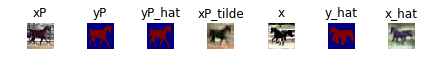

===> End of epoch 41 / 100 	 Time Taken: 5.32 sec

===> Start of epoch 42 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[42/100][0/50] in 0.265s (0.034,0.200,0.032) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.168/0.128 


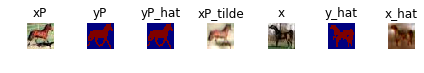

===> End of epoch 42 / 100 	 Time Taken: 5.39 sec



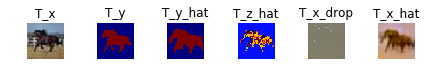

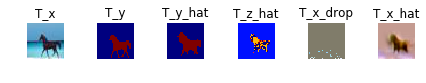

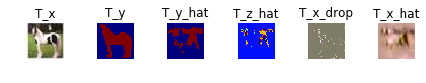

EVAL at epoch 42 ==> CE = 0.883, A_L1 = 0.195, P_L1 = 0.195
EVAL at epoch 42 [127 images in 1.57 sec] ==> {'Overall Acc': 0.8433040108267716, 'Mean Acc': 0.8039349163067655, 'FreqW Acc': 0.734159233273245, 'Mean IoU': 0.6861376778622938}
Per-class IoU:
Background: 0.80
Horse: 0.57

===> Start of epoch 43 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[43/100][0/50] in 0.258s (0.035,0.193,0.031) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.119/0.143 


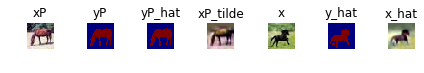

===> End of epoch 43 / 100 	 Time Taken: 5.20 sec

===> Start of epoch 44 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[44/100][0/50] in 0.271s (0.033,0.203,0.035) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.133/0.149 


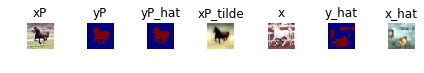

===> End of epoch 44 / 100 	 Time Taken: 5.64 sec



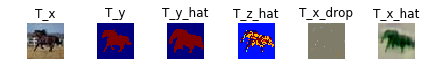

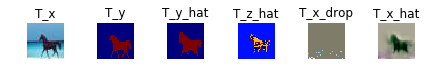

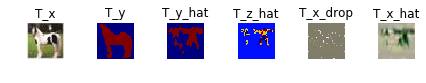

EVAL at epoch 44 ==> CE = 0.894, A_L1 = 0.194, P_L1 = 0.194
EVAL at epoch 44 [127 images in 1.81 sec] ==> {'Overall Acc': 0.8391978346456693, 'Mean Acc': 0.8051604323316959, 'FreqW Acc': 0.7293002242963106, 'Mean IoU': 0.6822592261840477}
Per-class IoU:
Background: 0.80
Horse: 0.57

===> Start of epoch 45 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[45/100][0/50] in 0.576s (0.330,0.212,0.034) D/G: 0.000/0.001 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.163/0.148 


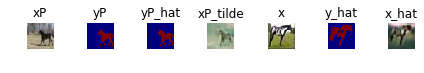

===> End of epoch 45 / 100 	 Time Taken: 5.52 sec

===> Start of epoch 46 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[46/100][0/50] in 0.318s (0.034,0.254,0.031) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.097/0.133 


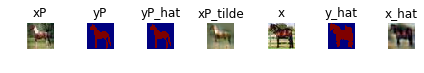

===> End of epoch 46 / 100 	 Time Taken: 5.44 sec



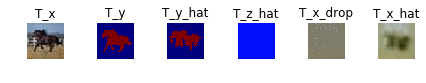

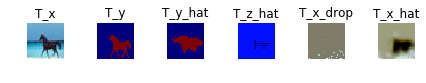

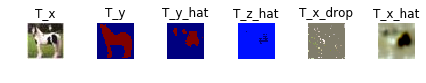

EVAL at epoch 46 ==> CE = 0.428, A_L1 = 0.215, P_L1 = 0.215
EVAL at epoch 46 [127 images in 1.58 sec] ==> {'Overall Acc': 0.812007874015748, 'Mean Acc': 0.7233784014722608, 'FreqW Acc': 0.6803971931617873, 'Mean IoU': 0.6107958689055635}
Per-class IoU:
Background: 0.78
Horse: 0.44

===> Start of epoch 47 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[47/100][0/50] in 0.301s (0.042,0.227,0.032) D/G: 0.000/0.000 P_CE/A_CE: 0.229/0.000 P_L1/A_L1: 0.123/0.144 


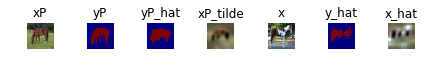

===> End of epoch 47 / 100 	 Time Taken: 5.29 sec

===> Start of epoch 48 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[48/100][0/50] in 0.270s (0.034,0.204,0.032) D/G: 0.000/0.000 P_CE/A_CE: 0.089/0.000 P_L1/A_L1: 0.100/0.139 


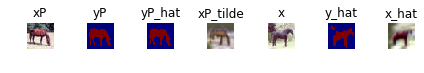

===> End of epoch 48 / 100 	 Time Taken: 5.83 sec



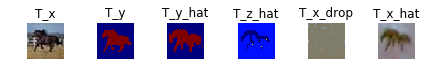

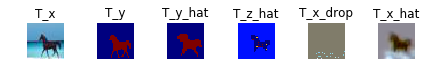

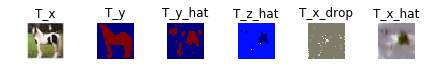

EVAL at epoch 48 ==> CE = 0.552, A_L1 = 0.190, P_L1 = 0.190
EVAL at epoch 48 [127 images in 1.88 sec] ==> {'Overall Acc': 0.8446419783464567, 'Mean Acc': 0.7805387405087498, 'FreqW Acc': 0.7310802222447682, 'Mean IoU': 0.6755620046297147}
Per-class IoU:
Background: 0.81
Horse: 0.54

===> Start of epoch 49 / 100
X2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
ZY2X: learning rate = 0.0100000
D: learning rate = 0.0100000
[49/100][0/50] in 0.336s (0.041,0.263,0.032) D/G: 0.000/0.000 P_CE/A_CE: 0.030/0.000 P_L1/A_L1: 0.137/0.140 


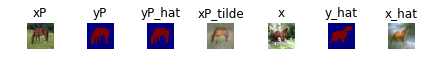

===> End of epoch 49 / 100 	 Time Taken: 5.38 sec

===> Start of epoch 50 / 100
X2Z: learning rate = 0.0000980
Z2Y: learning rate = 0.0000980
ZY2X: learning rate = 0.0098039
D: learning rate = 0.0098039
[50/100][0/50] in 0.751s (0.499,0.220,0.032) D/G: 0.000/0.000 P_CE/A_CE: 0.014/0.000 P_L1/A_L1: 0.140/0.144 


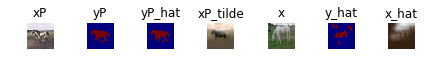

===> End of epoch 50 / 100 	 Time Taken: 6.13 sec



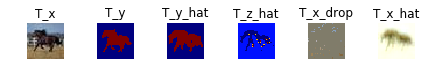

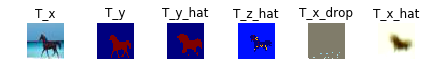

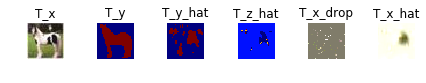

EVAL at epoch 50 ==> CE = 0.689, A_L1 = 0.497, P_L1 = 0.497
EVAL at epoch 50 [127 images in 1.86 sec] ==> {'Overall Acc': 0.8447726993110236, 'Mean Acc': 0.7841010423044465, 'FreqW Acc': 0.732045626180609, 'Mean IoU': 0.6776690774797627}
Per-class IoU:
Background: 0.81
Horse: 0.55

===> Start of epoch 51 / 100
X2Z: learning rate = 0.0000961
Z2Y: learning rate = 0.0000961
ZY2X: learning rate = 0.0096078
D: learning rate = 0.0096078
[51/100][0/50] in 0.375s (0.037,0.294,0.045) D/G: 0.000/0.000 P_CE/A_CE: 0.007/0.000 P_L1/A_L1: 0.374/0.214 


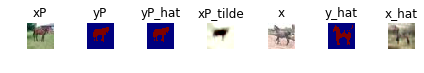

===> End of epoch 51 / 100 	 Time Taken: 5.48 sec

===> Start of epoch 52 / 100
X2Z: learning rate = 0.0000941
Z2Y: learning rate = 0.0000941
ZY2X: learning rate = 0.0094118
D: learning rate = 0.0094118
[52/100][0/50] in 0.269s (0.034,0.201,0.034) D/G: 0.000/0.001 P_CE/A_CE: 0.003/0.000 P_L1/A_L1: 0.117/0.179 


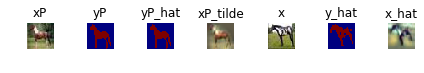

===> End of epoch 52 / 100 	 Time Taken: 5.79 sec



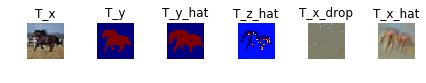

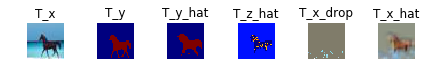

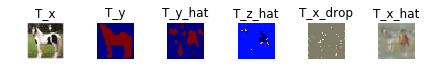

EVAL at epoch 52 ==> CE = 0.748, A_L1 = 0.198, P_L1 = 0.198
EVAL at epoch 52 [127 images in 2.10 sec] ==> {'Overall Acc': 0.8447265625, 'Mean Acc': 0.7853196978169896, 'FreqW Acc': 0.7322611361242017, 'Mean IoU': 0.6782847411700239}
Per-class IoU:
Background: 0.81
Horse: 0.55

===> Start of epoch 53 / 100
X2Z: learning rate = 0.0000922
Z2Y: learning rate = 0.0000922
ZY2X: learning rate = 0.0092157
D: learning rate = 0.0092157
[53/100][0/50] in 0.362s (0.042,0.280,0.040) D/G: 0.000/0.000 P_CE/A_CE: 0.003/0.000 P_L1/A_L1: 0.144/0.133 


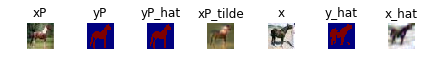

===> End of epoch 53 / 100 	 Time Taken: 5.48 sec

===> Start of epoch 54 / 100
X2Z: learning rate = 0.0000902
Z2Y: learning rate = 0.0000902
ZY2X: learning rate = 0.0090196
D: learning rate = 0.0090196
[54/100][0/50] in 0.327s (0.033,0.257,0.036) D/G: 0.000/0.000 P_CE/A_CE: 0.002/0.000 P_L1/A_L1: 0.146/0.157 


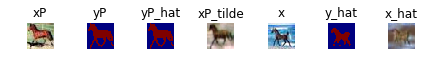

===> End of epoch 54 / 100 	 Time Taken: 5.58 sec



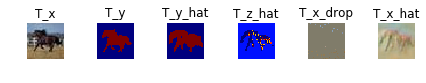

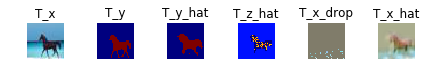

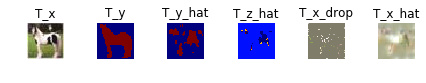

EVAL at epoch 54 ==> CE = 0.759, A_L1 = 0.237, P_L1 = 0.237
EVAL at epoch 54 [127 images in 1.67 sec] ==> {'Overall Acc': 0.8462875246062992, 'Mean Acc': 0.7894023786942502, 'FreqW Acc': 0.7350004590667221, 'Mean IoU': 0.6820931659175326}
Per-class IoU:
Background: 0.81
Horse: 0.55

===> Start of epoch 55 / 100
X2Z: learning rate = 0.0000882
Z2Y: learning rate = 0.0000882
ZY2X: learning rate = 0.0088235
D: learning rate = 0.0088235
[55/100][0/50] in 0.643s (0.368,0.241,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.002/0.000 P_L1/A_L1: 0.163/0.123 


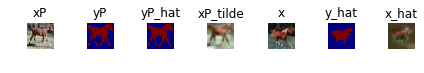

===> End of epoch 55 / 100 	 Time Taken: 5.67 sec

===> Start of epoch 56 / 100
X2Z: learning rate = 0.0000863
Z2Y: learning rate = 0.0000863
ZY2X: learning rate = 0.0086275
D: learning rate = 0.0086275
[56/100][0/50] in 0.251s (0.034,0.186,0.032) D/G: 0.000/0.000 P_CE/A_CE: 0.002/0.000 P_L1/A_L1: 0.161/0.133 


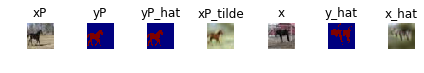

===> End of epoch 56 / 100 	 Time Taken: 5.76 sec



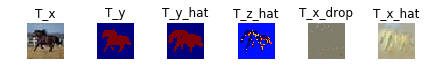

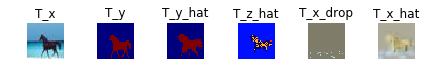

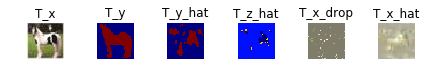

EVAL at epoch 56 ==> CE = 0.793, A_L1 = 0.255, P_L1 = 0.255
EVAL at epoch 56 [127 images in 1.84 sec] ==> {'Overall Acc': 0.8461183562992126, 'Mean Acc': 0.7908948092285775, 'FreqW Acc': 0.7351131852813817, 'Mean IoU': 0.6827015496749473}
Per-class IoU:
Background: 0.81
Horse: 0.56

===> Start of epoch 57 / 100
X2Z: learning rate = 0.0000843
Z2Y: learning rate = 0.0000843
ZY2X: learning rate = 0.0084314
D: learning rate = 0.0084314
[57/100][0/50] in 0.295s (0.041,0.223,0.031) D/G: 0.000/0.001 P_CE/A_CE: 0.001/0.000 P_L1/A_L1: 0.100/0.165 


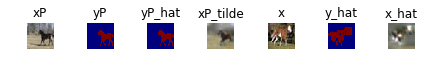

===> End of epoch 57 / 100 	 Time Taken: 5.22 sec

===> Start of epoch 58 / 100
X2Z: learning rate = 0.0000824
Z2Y: learning rate = 0.0000824
ZY2X: learning rate = 0.0082353
D: learning rate = 0.0082353
[58/100][0/50] in 0.243s (0.034,0.177,0.032) D/G: 0.000/0.000 P_CE/A_CE: 0.001/0.000 P_L1/A_L1: 0.127/0.128 


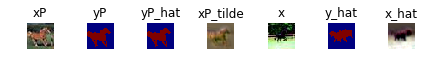

===> End of epoch 58 / 100 	 Time Taken: 5.48 sec



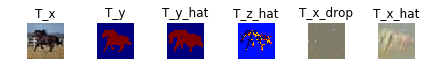

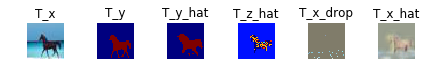

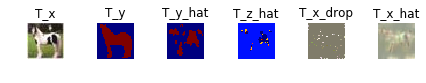

EVAL at epoch 58 ==> CE = 0.810, A_L1 = 0.233, P_L1 = 0.233
EVAL at epoch 58 [127 images in 1.59 sec] ==> {'Overall Acc': 0.84642593503937, 'Mean Acc': 0.7907899571316765, 'FreqW Acc': 0.7354596888020669, 'Mean IoU': 0.6829700236138344}
Per-class IoU:
Background: 0.81
Horse: 0.56

===> Start of epoch 59 / 100
X2Z: learning rate = 0.0000804
Z2Y: learning rate = 0.0000804
ZY2X: learning rate = 0.0080392
D: learning rate = 0.0080392
[59/100][0/50] in 0.294s (0.037,0.224,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.001/0.000 P_L1/A_L1: 0.104/0.118 


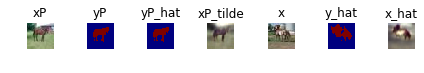

===> End of epoch 59 / 100 	 Time Taken: 5.35 sec

===> Start of epoch 60 / 100
X2Z: learning rate = 0.0000784
Z2Y: learning rate = 0.0000784
ZY2X: learning rate = 0.0078431
D: learning rate = 0.0078431
[60/100][0/50] in 0.778s (0.518,0.228,0.033) D/G: 0.000/0.000 P_CE/A_CE: 0.001/0.000 P_L1/A_L1: 0.132/0.155 


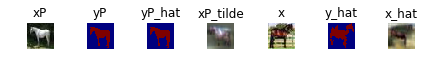

===> End of epoch 60 / 100 	 Time Taken: 5.94 sec



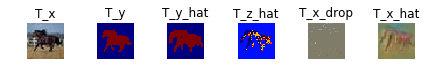

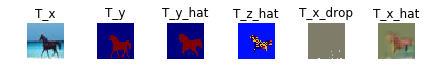

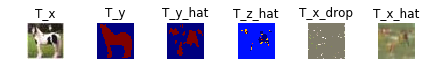

EVAL at epoch 60 ==> CE = 0.821, A_L1 = 0.187, P_L1 = 0.187
EVAL at epoch 60 [127 images in 1.92 sec] ==> {'Overall Acc': 0.8457723302165354, 'Mean Acc': 0.7887462432502468, 'FreqW Acc': 0.7342456722516424, 'Mean IoU': 0.6812066078995731}
Per-class IoU:
Background: 0.81
Horse: 0.55

===> Start of epoch 61 / 100
X2Z: learning rate = 0.0000765
Z2Y: learning rate = 0.0000765
ZY2X: learning rate = 0.0076471
D: learning rate = 0.0076471
[61/100][0/50] in 0.577s (0.295,0.248,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.001/0.000 P_L1/A_L1: 0.143/0.156 


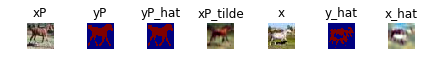

===> End of epoch 61 / 100 	 Time Taken: 5.83 sec

===> Start of epoch 62 / 100
X2Z: learning rate = 0.0000745
Z2Y: learning rate = 0.0000745
ZY2X: learning rate = 0.0074510
D: learning rate = 0.0074510
[62/100][0/50] in 0.634s (0.314,0.276,0.045) D/G: 0.000/0.000 P_CE/A_CE: 0.001/0.000 P_L1/A_L1: 0.108/0.089 


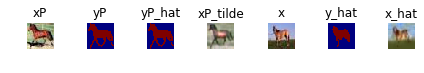

===> End of epoch 62 / 100 	 Time Taken: 5.83 sec



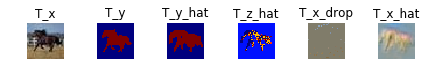

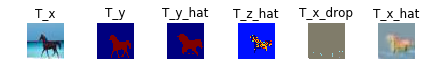

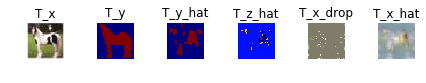

EVAL at epoch 62 ==> CE = 0.846, A_L1 = 0.236, P_L1 = 0.236
EVAL at epoch 62 [127 images in 1.85 sec] ==> {'Overall Acc': 0.8454878198818898, 'Mean Acc': 0.7880229836764332, 'FreqW Acc': 0.7337518293490317, 'Mean IoU': 0.680525370460334}
Per-class IoU:
Background: 0.81
Horse: 0.55

===> Start of epoch 63 / 100
X2Z: learning rate = 0.0000725
Z2Y: learning rate = 0.0000725
ZY2X: learning rate = 0.0072549
D: learning rate = 0.0072549
[63/100][0/50] in 0.600s (0.306,0.251,0.043) D/G: 0.000/0.000 P_CE/A_CE: 0.001/0.000 P_L1/A_L1: 0.105/0.137 


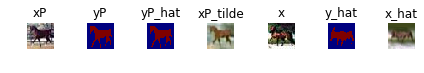

===> End of epoch 63 / 100 	 Time Taken: 5.37 sec

===> Start of epoch 64 / 100
X2Z: learning rate = 0.0000706
Z2Y: learning rate = 0.0000706
ZY2X: learning rate = 0.0070588
D: learning rate = 0.0070588
[64/100][0/50] in 0.497s (0.223,0.241,0.033) D/G: 0.000/0.000 P_CE/A_CE: 0.001/0.000 P_L1/A_L1: 0.106/0.128 


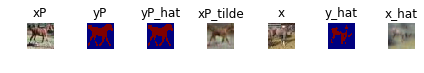

===> End of epoch 64 / 100 	 Time Taken: 5.61 sec



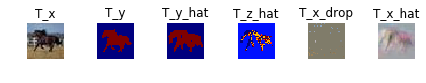

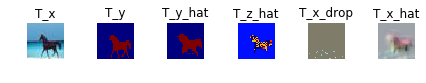

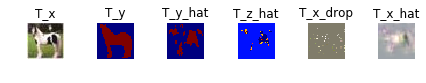

EVAL at epoch 64 ==> CE = 0.855, A_L1 = 0.252, P_L1 = 0.252
EVAL at epoch 64 [127 images in 1.97 sec] ==> {'Overall Acc': 0.8457185039370079, 'Mean Acc': 0.7896907776050135, 'FreqW Acc': 0.7343819722304606, 'Mean IoU': 0.6816498855214512}
Per-class IoU:
Background: 0.81
Horse: 0.55

===> Start of epoch 65 / 100
X2Z: learning rate = 0.0000686
Z2Y: learning rate = 0.0000686
ZY2X: learning rate = 0.0068627
D: learning rate = 0.0068627
[65/100][0/50] in 0.803s (0.548,0.221,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.001/0.000 P_L1/A_L1: 0.196/0.093 


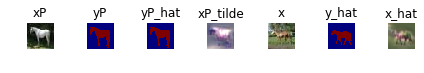

===> End of epoch 65 / 100 	 Time Taken: 5.64 sec

===> Start of epoch 66 / 100
X2Z: learning rate = 0.0000667
Z2Y: learning rate = 0.0000667
ZY2X: learning rate = 0.0066667
D: learning rate = 0.0066667
[66/100][0/50] in 0.241s (0.034,0.173,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.001/0.000 P_L1/A_L1: 0.142/0.105 


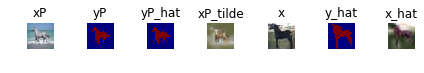

===> End of epoch 66 / 100 	 Time Taken: 5.16 sec



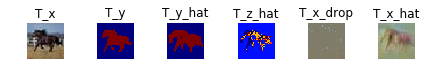

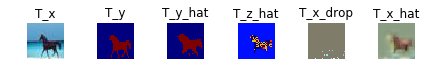

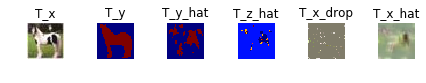

EVAL at epoch 66 ==> CE = 0.861, A_L1 = 0.198, P_L1 = 0.198
EVAL at epoch 66 [127 images in 1.56 sec] ==> {'Overall Acc': 0.845826156496063, 'Mean Acc': 0.7914404308409542, 'FreqW Acc': 0.7348763238124959, 'Mean IoU': 0.6826788822898542}
Per-class IoU:
Background: 0.81
Horse: 0.56

===> Start of epoch 67 / 100
X2Z: learning rate = 0.0000647
Z2Y: learning rate = 0.0000647
ZY2X: learning rate = 0.0064706
D: learning rate = 0.0064706
[67/100][0/50] in 0.329s (0.035,0.260,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.083/0.102 


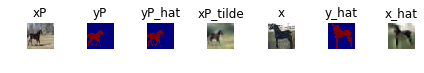

===> End of epoch 67 / 100 	 Time Taken: 5.19 sec

===> Start of epoch 68 / 100
X2Z: learning rate = 0.0000627
Z2Y: learning rate = 0.0000627
ZY2X: learning rate = 0.0062745
D: learning rate = 0.0062745
[68/100][0/50] in 0.286s (0.033,0.218,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.102/0.120 


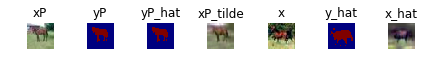

===> End of epoch 68 / 100 	 Time Taken: 5.67 sec



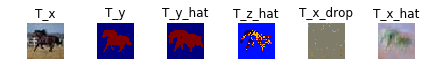

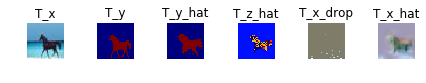

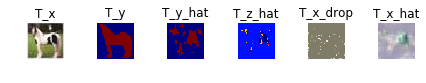

EVAL at epoch 68 ==> CE = 0.863, A_L1 = 0.237, P_L1 = 0.237
EVAL at epoch 68 [127 images in 1.83 sec] ==> {'Overall Acc': 0.8461568036417323, 'Mean Acc': 0.7914516923883033, 'FreqW Acc': 0.7352752634019183, 'Mean IoU': 0.6830328378385547}
Per-class IoU:
Background: 0.81
Horse: 0.56

===> Start of epoch 69 / 100
X2Z: learning rate = 0.0000608
Z2Y: learning rate = 0.0000608
ZY2X: learning rate = 0.0060784
D: learning rate = 0.0060784
[69/100][0/50] in 0.287s (0.035,0.217,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.001/0.000 P_L1/A_L1: 0.126/0.123 


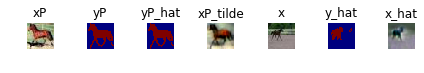

===> End of epoch 69 / 100 	 Time Taken: 5.14 sec

===> Start of epoch 70 / 100
X2Z: learning rate = 0.0000588
Z2Y: learning rate = 0.0000588
ZY2X: learning rate = 0.0058824
D: learning rate = 0.0058824
[70/100][0/50] in 0.573s (0.329,0.211,0.033) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.104/0.158 


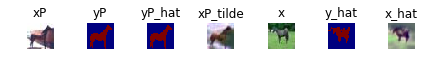

===> End of epoch 70 / 100 	 Time Taken: 5.47 sec



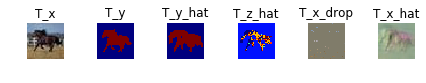

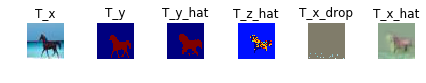

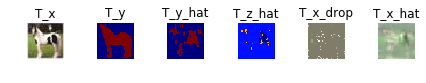

EVAL at epoch 70 ==> CE = 0.886, A_L1 = 0.222, P_L1 = 0.222
EVAL at epoch 70 [127 images in 1.54 sec] ==> {'Overall Acc': 0.8457492618110236, 'Mean Acc': 0.7911173572649282, 'FreqW Acc': 0.734717224653332, 'Mean IoU': 0.682429768699178}
Per-class IoU:
Background: 0.81
Horse: 0.56

===> Start of epoch 71 / 100
X2Z: learning rate = 0.0000569
Z2Y: learning rate = 0.0000569
ZY2X: learning rate = 0.0056863
D: learning rate = 0.0056863
[71/100][0/50] in 0.333s (0.035,0.260,0.038) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.118/0.161 


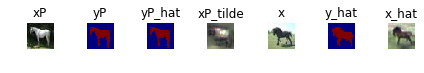

===> End of epoch 71 / 100 	 Time Taken: 5.39 sec

===> Start of epoch 72 / 100
X2Z: learning rate = 0.0000549
Z2Y: learning rate = 0.0000549
ZY2X: learning rate = 0.0054902
D: learning rate = 0.0054902
[72/100][0/50] in 0.272s (0.034,0.206,0.032) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.133/0.127 


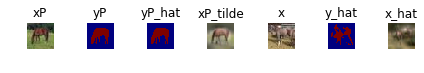

===> End of epoch 72 / 100 	 Time Taken: 5.95 sec



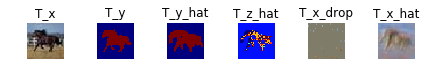

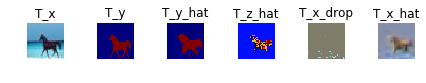

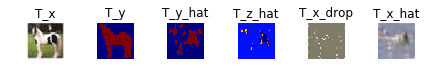

EVAL at epoch 72 ==> CE = 0.894, A_L1 = 0.214, P_L1 = 0.214
EVAL at epoch 72 [127 images in 1.95 sec] ==> {'Overall Acc': 0.8459722563976378, 'Mean Acc': 0.7919966959210762, 'FreqW Acc': 0.7351663966965748, 'Mean IoU': 0.6831216732917681}
Per-class IoU:
Background: 0.81
Horse: 0.56

===> Start of epoch 73 / 100
X2Z: learning rate = 0.0000529
Z2Y: learning rate = 0.0000529
ZY2X: learning rate = 0.0052941
D: learning rate = 0.0052941
[73/100][0/50] in 0.320s (0.036,0.251,0.033) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.120/0.101 


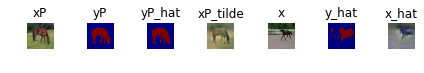

===> End of epoch 73 / 100 	 Time Taken: 5.37 sec

===> Start of epoch 74 / 100
X2Z: learning rate = 0.0000510
Z2Y: learning rate = 0.0000510
ZY2X: learning rate = 0.0050980
D: learning rate = 0.0050980
[74/100][0/50] in 0.336s (0.036,0.259,0.041) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.091/0.098 


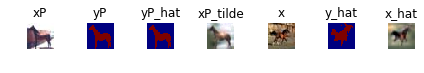

===> End of epoch 74 / 100 	 Time Taken: 6.12 sec



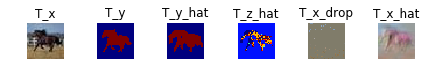

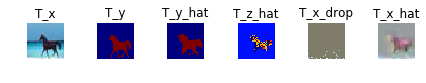

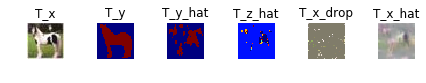

EVAL at epoch 74 ==> CE = 0.922, A_L1 = 0.221, P_L1 = 0.221
EVAL at epoch 74 [127 images in 1.95 sec] ==> {'Overall Acc': 0.8448111466535433, 'Mean Acc': 0.791927692726543, 'FreqW Acc': 0.733758165426816, 'Mean IoU': 0.6818633002802894}
Per-class IoU:
Background: 0.81
Horse: 0.56

===> Start of epoch 75 / 100
X2Z: learning rate = 0.0000490
Z2Y: learning rate = 0.0000490
ZY2X: learning rate = 0.0049020
D: learning rate = 0.0049020
[75/100][0/50] in 0.912s (0.618,0.259,0.035) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.105/0.168 


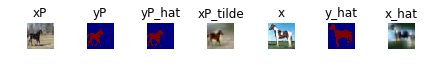

===> End of epoch 75 / 100 	 Time Taken: 6.29 sec

===> Start of epoch 76 / 100
X2Z: learning rate = 0.0000471
Z2Y: learning rate = 0.0000471
ZY2X: learning rate = 0.0047059
D: learning rate = 0.0047059
[76/100][0/50] in 0.324s (0.040,0.249,0.035) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.092/0.113 


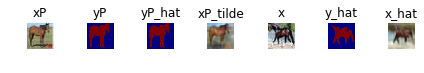

===> End of epoch 76 / 100 	 Time Taken: 6.04 sec



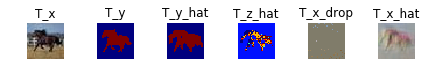

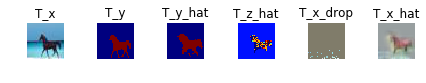

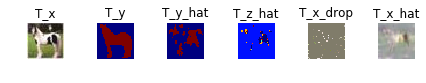

EVAL at epoch 76 ==> CE = 0.919, A_L1 = 0.225, P_L1 = 0.225
EVAL at epoch 76 [127 images in 1.94 sec] ==> {'Overall Acc': 0.8453109621062992, 'Mean Acc': 0.7928723383698808, 'FreqW Acc': 0.7345499243126278, 'Mean IoU': 0.6828755476742662}
Per-class IoU:
Background: 0.81
Horse: 0.56

===> Start of epoch 77 / 100
X2Z: learning rate = 0.0000451
Z2Y: learning rate = 0.0000451
ZY2X: learning rate = 0.0045098
D: learning rate = 0.0045098
[77/100][0/50] in 0.315s (0.039,0.245,0.032) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.105/0.094 


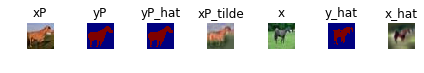

===> End of epoch 77 / 100 	 Time Taken: 5.25 sec

===> Start of epoch 78 / 100
X2Z: learning rate = 0.0000431
Z2Y: learning rate = 0.0000431
ZY2X: learning rate = 0.0043137
D: learning rate = 0.0043137
[78/100][0/50] in 0.269s (0.032,0.206,0.032) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.159/0.130 


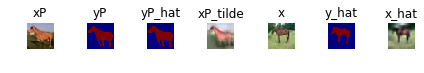

===> End of epoch 78 / 100 	 Time Taken: 5.73 sec



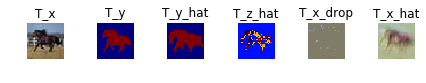

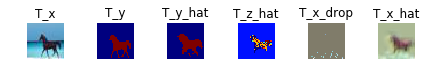

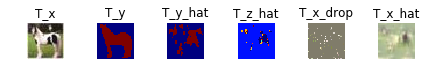

EVAL at epoch 78 ==> CE = 0.925, A_L1 = 0.233, P_L1 = 0.233
EVAL at epoch 78 [127 images in 1.71 sec] ==> {'Overall Acc': 0.844841904527559, 'Mean Acc': 0.7930548838719567, 'FreqW Acc': 0.7340222107628902, 'Mean IoU': 0.6824739214215914}
Per-class IoU:
Background: 0.81
Horse: 0.56

===> Start of epoch 79 / 100
X2Z: learning rate = 0.0000412
Z2Y: learning rate = 0.0000412
ZY2X: learning rate = 0.0041176
D: learning rate = 0.0041176
[79/100][0/50] in 0.302s (0.035,0.234,0.033) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.103/0.113 


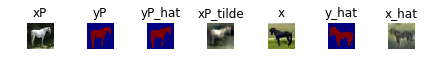

===> End of epoch 79 / 100 	 Time Taken: 5.33 sec

===> Start of epoch 80 / 100
X2Z: learning rate = 0.0000392
Z2Y: learning rate = 0.0000392
ZY2X: learning rate = 0.0039216
D: learning rate = 0.0039216
[80/100][0/50] in 0.551s (0.335,0.182,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.081/0.101 


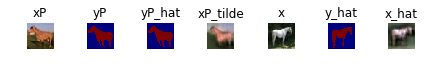

===> End of epoch 80 / 100 	 Time Taken: 5.94 sec



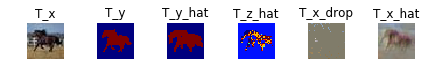

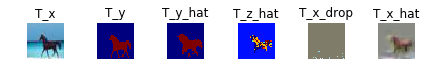

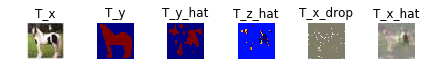

EVAL at epoch 80 ==> CE = 0.917, A_L1 = 0.187, P_L1 = 0.187
EVAL at epoch 80 [127 images in 1.78 sec] ==> {'Overall Acc': 0.84544937253937, 'Mean Acc': 0.7956493865797349, 'FreqW Acc': 0.7352679601492168, 'Mean IoU': 0.684432383545535}
Per-class IoU:
Background: 0.81
Horse: 0.56

===> Start of epoch 81 / 100
X2Z: learning rate = 0.0000373
Z2Y: learning rate = 0.0000373
ZY2X: learning rate = 0.0037255
D: learning rate = 0.0037255
[81/100][0/50] in 0.305s (0.040,0.231,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.096/0.100 


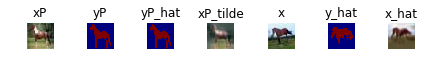

===> End of epoch 81 / 100 	 Time Taken: 5.33 sec

===> Start of epoch 82 / 100
X2Z: learning rate = 0.0000353
Z2Y: learning rate = 0.0000353
ZY2X: learning rate = 0.0035294
D: learning rate = 0.0035294
[82/100][0/50] in 0.280s (0.034,0.214,0.032) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.106/0.117 


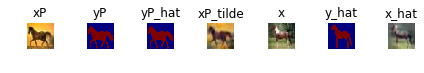

===> End of epoch 82 / 100 	 Time Taken: 5.39 sec



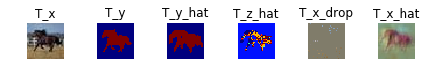

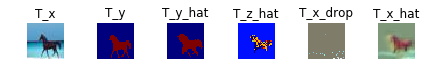

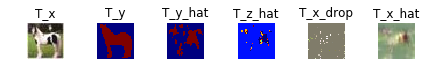

EVAL at epoch 82 ==> CE = 0.929, A_L1 = 0.186, P_L1 = 0.186
EVAL at epoch 82 [127 images in 1.58 sec] ==> {'Overall Acc': 0.8456108513779528, 'Mean Acc': 0.7933992072872834, 'FreqW Acc': 0.7350170750632983, 'Mean IoU': 0.6834624417944181}
Per-class IoU:
Background: 0.81
Horse: 0.56

===> Start of epoch 83 / 100
X2Z: learning rate = 0.0000333
Z2Y: learning rate = 0.0000333
ZY2X: learning rate = 0.0033333
D: learning rate = 0.0033333
[83/100][0/50] in 0.302s (0.038,0.231,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.116/0.102 


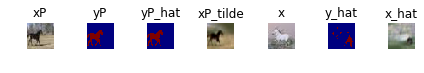

===> End of epoch 83 / 100 	 Time Taken: 5.49 sec

===> Start of epoch 84 / 100
X2Z: learning rate = 0.0000314
Z2Y: learning rate = 0.0000314
ZY2X: learning rate = 0.0031373
D: learning rate = 0.0031373
[84/100][0/50] in 0.293s (0.034,0.221,0.038) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.105/0.095 


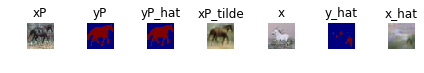

===> End of epoch 84 / 100 	 Time Taken: 6.03 sec



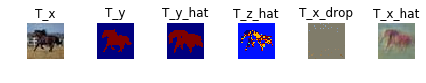

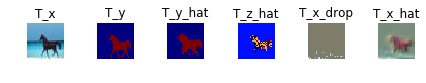

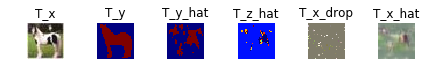

EVAL at epoch 84 ==> CE = 0.938, A_L1 = 0.187, P_L1 = 0.187
EVAL at epoch 84 [127 images in 1.90 sec] ==> {'Overall Acc': 0.8449264886811023, 'Mean Acc': 0.795333260264111, 'FreqW Acc': 0.7345737704749032, 'Mean IoU': 0.6837175322691565}
Per-class IoU:
Background: 0.81
Horse: 0.56

===> Start of epoch 85 / 100
X2Z: learning rate = 0.0000294
Z2Y: learning rate = 0.0000294
ZY2X: learning rate = 0.0029412
D: learning rate = 0.0029412
[85/100][0/50] in 0.594s (0.341,0.220,0.034) D/G: 0.000/0.000 P_CE/A_CE: 0.000/0.000 P_L1/A_L1: 0.084/0.119 


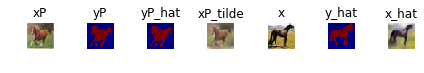

In [ ]:
for epoch in range(opt.start_epoch, opt.niter):
    # on begin epoch
    adjust_lr(epoch)
    epoch_start_time = time.time()

    for i in range(len(x_loader)):
        tt0 = time.time()
        if g_it < 25 or g_it % 500 == 0:
            D_ITERS, G_ITERS = 20, 1 # 100, 1
        else:
            D_ITERS, G_ITERS = 2, 1 # 5, 1
        if opt.updates['D'] != 2:
            D_ITERS = 0
    
        # -------------------------------------------------------------------
        #        Optimize over D
        # -------------------------------------------------------------------
        # TODO: D(x, y_hat) v.s. D(x_hat, log_y): pix2pixHD or sngan_projection
        for d_i in range(D_ITERS):
            v_x = generate_var_x()
            d_loss = D_step(v_x)
            stats['D'] = -d_loss.data[0]

        # -------------------------------------------------------------------
        #        Optimize over FX2Z, HZ2Y, GZY2X
        # -------------------------------------------------------------------
        for g_i in range(G_ITERS):
            tt1 = time.time()
            images = {}
            
            # -------------------------------------------------------------------
            # paired X, Y
            g_losses = []
            v_x, v_y_int, log_y = generate_var_xy()

            # log p(y | x)
            z_hat, y_hat, P_CE = Y_step(v_x, v_y_int)
            g_losses.append( lambda_y * P_CE ) # CE
            stats['P_CE'] = P_CE.data[0]

            # visdom
            images['xP'] = v_x.data.cpu()
            images['yP'] = v_y_int.data.cpu().numpy()
            images['yP_hat'] = y_hat.data.cpu().numpy().argmax(1)

            # log p(x | y)
            if opt.updates['ZY2X'] == 2:
                v_x_drop = mask_drop(v_x)
                x_tilde, P_L1 = X_step(z_hat, v_x_drop, v_x)
                g_losses.append( lambda_x * P_L1 ) # L1
                stats['P_L1'] = P_L1.data[0]

                # visdom
                images['xP_tilde'] = x_tilde.data.cpu()

            update_FHG(g_losses)

            tt2 = time.time()
            # -------------------------------------------------------------------
            # X augmented
            # TODO: coeffs for g_losses: L1 and (D_R - D_F)^2 should be weighted

            # log p(x)
            if opt.updates['ZY2X'] > 0 and opt.updates['X2Z'] > 0:
                g_losses = []
                v_x = generate_var_x()
                v_x_drop = mask_drop(v_x)

                z_hat, y_hat, A_CE = Y_step(v_x, None)
                x_hat, A_L1 = X_step(z_hat, v_x_drop, v_x)

                g_losses.append( lambda_x * A_L1 ) # L1
                stats['A_L1'] = A_L1.data[0]

                if opt.updates['D'] > 0:
                    E_q_G = net['D']( x_hat ).mean()
                    E_p_G = net['D']( v_x ).mean()
                    g_loss = (E_q_G - E_p_G).pow(2)
                    g_losses.append( lambda_x * g_loss )
                    stats['G'] = g_loss.data[0]

                update_FHG(g_losses)

                # visdom
                images['x'] = v_x.data.cpu()
                images['y_hat'] = y_hat.data.cpu().numpy().argmax(1)
                images['x_hat'] = x_hat.data.cpu()
        
        # time spent per sample
        tt3 = time.time()

        # -------------------------------------------------------------------
        # print & plot
        if i % 50 == 0:
            print('[{epoch}/{nepoch}][{iter}/{niter}] in {t:.3f}s ({t01:.3f},{t12:.3f},{t23:.3f}) '
                  'D/G: {D:.3f}/{G:.3f} '
                  'P_CE/A_CE: {P_CE:.3f}/{A_CE:.3f} '
                  'P_L1/A_L1: {P_L1:.3f}/{A_L1:.3f} '
                  ''.format(epoch=epoch, nepoch=opt.niter,
                            iter=i, niter=len(x_loader),
                            t=tt3-tt0, t01=tt1-tt0, t12=tt2-tt1, t23=tt3-tt2,
                            **stats))
            display_imgs(images, epoch, i)

    # -------------------------------------------------------------------
    # on end epoch
    print('===> End of epoch %d / %d \t Time Taken: %.2f sec\n' % \
                (epoch, opt.niter, time.time() - epoch_start_time))

    # evaluation & save (best only)
    if epoch % opt.save_every == 0:
        visualizer.save_webpage(prefix='train') # visualizer maintains a img_dict to be saved in webpage
        temp_mIoU = evaluation(epoch, do_G=True)
        if temp_mIoU >= mIoU:
            mIoU = temp_mIoU
            for k in net.keys():
                if opt.updates[k] == 2:
                    weights_fpath = os.path.join(opt.checkpoints_dir, opt.name, 'net%s.pth' % (k))
                    torch.save(net[k].state_dict(), weights_fpath)